<a href="https://colab.research.google.com/github/edwardgalligan3/SentimentAnalyzer/blob/main/austin_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Project Debater services for analyzing and finding insights in the survey data 
When you have a large collection of texts representing people’s opinions (such as product reviews, survey answers or  social media), it is difficult to understand the key issues that come up in the data. Going over thousands of comments is prohibitively expensive.  Existing automated approaches are often limited to identifying recurring phrases or concepts and the overall sentiment toward them, but do not provide detailed or actionable insights.

In this tutorial you will gain hands-on experience in using Project Debater services for analyzing and deriving insights from open-ended answers.  

The data we will use is a community survey conducted in the city of Austin in the years 2016 and 2017 (https://data.world/cityofaustin/mf9f-kvkk). In this survey, the citizens of Austin where asked "If there was ONE thing you could share with the Mayor regarding the City of Austin (any comment, suggestion, etc.), what would it be?". 

We will analyze their open-ended answers in different ways by using four Debater services, the *Argument Quality* service, the *Key Point Analysis (KPA)* service, the *Term Wikifier* service and the *Term Relater* service, and we will see how they can be combined into a powerful text analysis tool.

## 0. Environment Setup
Please replace 'PUT_YOUR_API_KEY_HERE' with the api-key retreived from the Early-Access-program site.
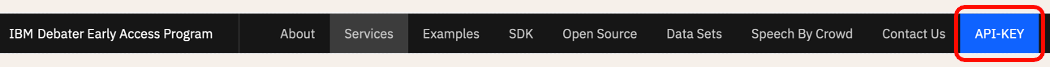

In [5]:
print('Set Api-Key:')
api_key = 'ffd94d42e491407c02c407e4577c7a7eL05'

if api_key == "PUT_YOUR_API_KEY_HERE":
    raise ValueError("Please set the api_key parameter with the value of the API KEY found in the API-KEY "
        "tab of the Early Access Program Website. It currently uses a placeholder template")

print('Install Early-Access-Program SDK:')
!wget -P . https://early-access-program.debater.res.ibm.com/sdk/python_api.tar.gz
!tar -xvf python_api.tar.gz
!cd python_api ; pip install .
!rm -f python_api.tar.gz*

print('Fetch additional code and data-set for the tutorial site: https://github.com/IBM/debater-eap-tutorial :')
!rm -f dataset_austin_sentences*
!rm -f austin_utils*

!wget -P . https://raw.githubusercontent.com/IBM/debater-eap-tutorial/main/survey_usecase/dataset_austin_sentences.csv
!wget -P . https://raw.githubusercontent.com/IBM/debater-eap-tutorial/main/survey_usecase/austin_utils.py

Set Api-Key:
Install Early-Access-Program SDK:
--2021-06-30 17:28:13--  https://early-access-program.debater.res.ibm.com/sdk/python_api.tar.gz
Resolving early-access-program.debater.res.ibm.com (early-access-program.debater.res.ibm.com)... 169.55.93.82
Connecting to early-access-program.debater.res.ibm.com (early-access-program.debater.res.ibm.com)|169.55.93.82|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 441774 (431K) [application/x-gzip]
Saving to: ‘./python_api.tar.gz’

python_api.tar.gz   100%[===================>] 431.42K  --.-KB/s    in 0.02s   

2021-06-30 17:28:13 (18.4 MB/s) - ‘./python_api.tar.gz’ saved [441774/441774]

python_api/
python_api/__init__.py
python_api/setup.py
python_api/README.md
python_api/debater_python_api/
python_api/debater_python_api/__init__.py
python_api/debater_python_api/examples/
python_api/debater_python_api/examples/__init__.py
python_api/debater_python_api/examples/evidence_detection_example.py
python_api/debater_python_

## 1. Run *Key Point Analysis* on 1000 randomly selected sentences from 2016 survey

### 1.1 Read random sample of 1000 sentences from 2016 comments
Let's take a look at the first 5 lines in the *dataset_austin_sentences.csv* file, which holds the Austin survey dataset.

In [6]:
file = open('dataset_austin_sentences.csv', 'r')
lines = file.readlines()
print('\n'.join(lines[:5]))

id,text,district,year

1,"Dissatisfied traffic and with traffic, timing of street lights.",7,2016

2,EXTREMELY dissatisfied with cit govt.,7,2016

3,"interfering in local businesses (Uber/Lyft, income property owners).",7,2016

4,"Also, extremely dissatisfied with all the free handouts to people who are perfectly capable of earning their own money.",7,2016



The file has all the survey answers after they were split into sentences. Each row in the file corresponds to a single sentence. Each row has the following attributes: \['id', 'text', 'district','year'\]. We will first read the attached csv file into the 'sentences' variable. 

In [8]:
import csv
import random


with open('./dataset_austin_sentences.csv') as csv_file:
    reader = csv.DictReader(csv_file)
    sentences = list(reader)

Let's have a look at the content *sentences* variable. 

In [9]:
print('There are %d sentences in the dataset' % len(sentences))
print('Each sentence is a dictionary with the following keys: %s' % str(sentences[0].keys()))

There are 6274 sentences in the dataset
Each sentence is a dictionary with the following keys: odict_keys(['id', 'text', 'district', 'year'])


Let's select only the sentences from the 2016 survey and randomly sample 1000 out of them. The *Key Point Analysis* service is able to run over hundreds of thousands of sentences, however since the computation is heavy in resources (particularly GPUs) the trial version is limited to 1000 sentences. Using a random.seed(0) is important since we already prepared a hot-cache over these sentences for a quicker *Key Point Analysis* run.

In [10]:
sentences_2016 = [sentence for sentence in sentences if sentence['year'] == '2016']
print('There are %d sentences in the 2016 survey' % len(sentences_2016))
random.seed(0)
random_sample_sentences_2016 = random.sample(sentences_2016, 1000)

There are 3005 sentences in the 2016 survey


### 1.2 Run *Key Point Analysis* on the random sample

Key point analysis is a novel and promising approach for summarization, with an important quantitative angle. This service summarizes a collection of comments on a given topic as a small set of key points. The salience of each key point is given by the number of its matching sentences in the given comments.

Before running the *Key Point Analysis* service we first need to initialize our client.  The DebaterApi object supplies the clients for the various Debater services.   The clients print information using the logger and a suitable verbosity level is should be set. The DebaterApi object is configured with an API key and used to obtain the keypoint client.

The *Key Point Analysis* service stores the data (and results cache) in a domain. A user can create several domains, one for each dataset. Domains are only accessible to the user who created them.  In this tutorial, we will run all *Key Point Analysis* jobs in the same domain named 'austin_demo'.

Full documentation of the *Key Point Analysis* service can be found [here](https://early-access-program.debater.res.ibm.com/docs/services/keypoints/keypoints_pydoc.html).


In [11]:
from debater_python_api.api.debater_api import DebaterApi
from austin_utils import init_logger
import os

init_logger()
debater_api = DebaterApi(apikey=api_key)
keypoints_client = debater_api.get_keypoints_client()
domain = 'austin_demo'

Exercise 1:

Let's define a method named *run_kpa*. The method receives a list of sentences (each sentence is a dictionary with the following keys: 'id','text') and runs *Key Point Analysis* on these sentences. The method also receives the *run_params* parameter, which enable us to customize and affect the *Key Point Analysis* operation.

In order to run *Key Point Analysis*, we need to:

1. Upload the comments into a domain using the **keypoints_client.upload_comments(domain=domain, comments_ids=sentences_ids, comments_texts=sentences_texts, dont_split=True)** method. This method receives the domain, a list of comment_ids and a list of comment_texts. By default, when uploading comments into a domain, the *Key Point Analysis* service splits the comments into sentences by default and runs a minor cleansing on the sentences. Since we already splitted the comments into sentences ourselves and we want to *Key Point Analysis* service to use them as is, we will set the *dont_split* parameter to True.

2. Wait till all comments in the domain are processed using the **keypoints_client.wait_till_all_comments_are_processed(domain=domain)** method.

3. Start a *Key Point Analysis* job using the **future = keypoints_client.start_kp_analysis_job(domain=domain, comments_ids=sentences_ids, run_params=run_params)** method. This method receives the domain, a list of comment_ids and a *run_params*. The run_params is a dictionary with various parameters for customizing the job. The job runs in an async manner therefore the method returns a future object.

4. Use the returned future and wait till results are available using the **kpa_result = future.get_result(high_verbosity=True, polling_timout_secs=5)** method. The method waits for the job to finish and eventually returns the result. The result is a dictionary containing the key points (sorted descendingly according to number of matched sentences) and for each key point has a list of matched sentences (sorted descendingly according to their match score). An additional 'none' key point is added which holds all the sentences that don't match any key point.

Our run_kpa method will return this result dictionary. It will also return the unique identifirt for this analysis called *job_id* retreived from the future. We will need this job_id in a following exercise.

In [ ]:
def run_kpa(sentences, run_params):
    sentences_texts = [sentence['text'] for sentence in sentences]
    sentences_ids = [sentence['id'] for sentence in sentences]

    print('Please implement')
    
    return kpa_result, future.get_job_id()




    

In [12]:
def run_kpa(sentences, run_params):
    sentences_texts = [sentence['text'] for sentence in sentences]
    sentences_ids = [sentence['id'] for sentence in sentences]

    keypoints_client.upload_comments(domain=domain, 
                                     comments_ids=sentences_ids, 
                                     comments_texts=sentences_texts, 
                                     dont_split=True)

    keypoints_client.wait_till_all_comments_are_processed(domain=domain)

    future = keypoints_client.start_kp_analysis_job(domain=domain, 
                                                    comments_ids=sentences_ids, 
                                                    run_params=run_params)

    kpa_result = future.get_result(high_verbosity=True, 
                                   polling_timout_secs=5)
    
    return kpa_result, future.get_job_id()

We will now use the method you implemented and run over the random sample and print the result. In order to limit the number of key points in the result to 20, we will use *run_params={'n_top_kps': 20}*.

In [13]:
from austin_utils import print_results

kpa_result_random_1000_2016, _ = run_kpa(random_sample_sentences_2016, {'n_top_kps': 20})
print_results(kpa_result_random_1000_2016, n_sentences_per_kp=2, title='Random sample 2016')

2021-06-30 17:49:02,308 [INFO] keypoints_client.py 284: uploading 1000 comments in batches
2021-06-30 17:49:02,312 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-06-30 17:49:02,765 [INFO] keypoints_client.py 301: uploaded 1000 comments, out of 1000
2021-06-30 17:49:02,767 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-06-30 17:49:08,723 [INFO] keypoints_client.py 313: domain: austin_demo, comments status: {'processed_comments': 3122, 'pending_comments': 0, 'processed_sentences': 3122}
2021-06-30 17:49:08,726 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-06-30 17:49:16,479 [INFO] keypoints_client.py 375: started a kp analysis job - domain: austin_demo, job_id: 60dcae9c93247fbd991aebb0
2021-06-30 17:49:16,480 [INFO] keypoints_client.py 214: 

Random sample 2016 coverage: 28.36
Random sample 2016 key points:
39 - We need better mass transit!
	- Need more bus routes!
	- NEED BETTER PUBLIC TRANSPORTATION
34 - Affordable housing, traffic, cleaner streets/roads.
	- TRAFFIC AND AFFORDABLE HOUSING ARE THE BIGGEST PROBLEM TO LIVING HERE.
	- Also, the traffic in Austin is ridiculous and the lack of public transportation needs
	  improvements.
24 - Affordable housing is very important.
	- Affordable housing is crucial, & keeping seniors in their homes is part of that challenge!
	- Affordable housing MUST become a reality/ahora!
21 - Homeowners taxes are a problem.
	- Cost of living here is to high & tax for my home is to high.
	- High property taxes seem to be one of the two reasons why people I know are leaving
	  Austin (traffic being the other reason).
19 - Water costs too much.
	- The cost or water is excessive and way too high.
	- Also, the cost of my water bill is insanely high and I am about to protest it!
17 - Provide public 

## 2. Run *Key Point Analysis* on 1000 top quality sentences from 2016 survey
### 2.1 Select top 1000 sentences from 2016 data using the *Argument Quality* service
The answers in the Austin Survey dataset vary in length, style and quality. Selecting the sentences randomly may lead to running over many sentences that are not very informative. Running over the randomly selected sentences reached a 28.36% coverage. This means that only 28.36% of the sentences matched a key point. In order to improve the coverage and the quality of our results, we will now run over higher quality sentences and select the 1000 sentences with the highest *Argument Quality* score. The *Argument Quality* service receives pairs of \[sentence, topic\] and returns a score indicating whether the sentence is phrased in grammatically correct, clear and concise language.   The ranking of the quality is based on the machine learning model, which was trained on human assesments of over 30,000 arguments. 

In [ ]:
from austin_utils import print_top_and_bottom_k_sentences

def get_top_quality_sentences(sentences, top_k, topic):    
    arg_quality_client = debater_api.get_argument_quality_client()
    sentences_topic = [{'sentence': sentence['text'], 'topic': topic} for sentence in sentences]
    arg_quality_scores = arg_quality_client.run(sentences_topic)
    sentences_and_scores = zip(sentences, arg_quality_scores)
    sentences_and_scores_sorted = sorted(sentences_and_scores, key=lambda x: x[1], reverse=True)
    sentences_sorted = [sentence for sentence, _ in sentences_and_scores_sorted]
    print_top_and_bottom_k_sentences(sentences_sorted, 10)
    return sentences_sorted[:top_k]

sentences_2016_top_1000_aq = get_top_quality_sentences(sentences_2016, 1000, 'Austin is a great place to live')

### 2.2 Run *Key Point Analysis* over the selected sentences
We will now run the *run_kpa* method over the top 1000 quality sentences

In [ ]:
kpa_result_top_aq_1000_2016, _ = run_kpa(sentences_2016_top_1000_aq, {'n_top_kps': 20})
print_results(kpa_result_top_aq_1000_2016, n_sentences_per_kp=2, title='Top aq 2016')

### 2.3 Customize key point analysis
It is possible to costumize and affect the analysis by passing different parameters in the *run_params* dictionary. In this subsection we will see few examples.

#### 2.3.1 Hierarchical key points
Often, few key points address a similar topic. In order to get an even clearer sumamry of the data, we can group similar key points together using the *Hierarchical Key Points* feature. To acrivate it we add two additional parameters to run_params: {'perform_kp_hierarchy': True, 'kp_hierarchy_threshold': 0.3}. *perform_kp_hierarchy* activates the feature and *kp_hierarchy_threshold* sets a threshold for grouping similar key points. The lower the threshold, more key points are grouped with lower similarity.

In [ ]:
kpa_result_top_aq_1000_2016, _ = run_kpa(sentences_2016_top_1000_aq, 
                                    {'n_top_kps': 20, 'perform_kp_hierarchy': True, 'kp_hierarchy_threshold': 0.3})
print_results(kpa_result_top_aq_1000_2016, n_sentences_per_kp=2, title='Top aq 2016, hierarchical')

#### 2.3.2 Increase coverage by decreasing the matching threshold
Running over higher quality sentences we managed to increase our coverage to 41.05%. In order to increase the coverage more, we will add another parameter to the run_params called *mapping_threshold*. 

The mapping_threshold is responsible of deciding whether a sentences matches (supports) a key point. Therefore reducing the threshold from the 0.99 default value makes more sentences match key points and increases the coverage, at the risk of reducing the precision.

In [ ]:
kpa_result_top_aq_1000_2016, kpa_top_aq_1000_2016_job_id = run_kpa(sentences_2016_top_1000_aq, 
                                                                {'n_top_kps': 20, 'mapping_threshold': 0.95})
print_results(kpa_result_top_aq_1000_2016, n_sentences_per_kp=2, title='Top aq 2016')

The coverage was indeed increased to about 50%. Let's examine the bottom 5 sentences that were matched to the first key point and make sure that the precision is still high.

In [ ]:
from austin_utils import print_bottom_matches_for_kp
print_bottom_matches_for_kp(kpa_result_top_aq_1000_2016, 'Traffic congestion needs major improvement', 5)

## 3. Run *Key Point Analysis* over 2017 survey using the key points from 2016 survey
### 3.1 Select top 1000 sentences from 2017 data using the *Argument Quality* service
It is very useful to be able to compare between different subsets of the data (compare between different years, different districts, etc'). We will demonstrate how easy it is to compare the 2017 data to the 2016 data. A similar comparisson can be done between districts or other subsets. 

Let's first filter the 2017 sentences and take the top 1000 quality sentences, as done for the 2016 sentences.

In [ ]:
sentences_2017 = [sentence for sentence in sentences if sentence['year'] == '2017']
sentences_2017_top_1000_aq = get_top_quality_sentences(sentences_2017, 1000, 'Austin is a great place to live')

### 3.2 Run *Key Point Analysis* over top 1000 quality 2017 sentences using the key points from 2016
Exercise 2:<br/>
In order to compare the 2017 sentences to 2016 sentences we will want to map the 2017 sentences to the same key points extracted on the 2016 sentences (otherwise different key points could be automattically extracted on the 2017 sentences and it would be hard to compare between them).

For this end we will reimplement the *run_kpa* method (please copy paste the previous one and modify it). This time the method will receive a new *key_points_by_job_id* parameter. This parameter is passed to the *key_points_by_job_id* parameter in the **future = keypoints_client.start_kp_analysis_job(domain=domain, comments_ids=sentences_ids, run_params=run_params, key_points_by_job_id=key_points_by_job_id)** method. When *None* is passed to *key_points_by_job_id*, key points are automatically extracted, however when it is set with a *job_id* of a previous job it uses the key points from that job and matches all sentences to them.

In [ ]:
def run_kpa(sentences, run_params, key_points_by_job_id=None):
    sentences_texts = [sentence['text'] for sentence in sentences]
    sentences_ids = [sentence['id'] for sentence in sentences]

    print('Please implement')
    
    return kpa_result, future.get_job_id()

Let's use the new *run_kpa* and provide it with the *top 1000 quality sentences from 2017* and the job_id of *top 1000 quality sentences from 2016*.

In [ ]:
kpa_result_top_aq_1000_2017, _ = run_kpa(sentences_2017_top_1000_aq, 
                                    {'n_top_kps': 20, 'mapping_threshold': 0.95}, kpa_top_aq_1000_2016_job_id)
print_results(kpa_result_top_aq_1000_2017, n_sentences_per_kp=2, title='Top aq 2017, using 2016 key points')

Since both jobs have the same key points, we can now easily compare the two results.

In [ ]:
from austin_utils import compare_results

compare_results(kpa_result_top_aq_1000_2016, '2016', kpa_result_top_aq_1000_2017, '2017')

Note: This comparision is for illustration only. Given that we ran on a subset of comments, the statistical significant of difference between the years is limited, except for the most recurring keypoints.

## 4. Deep dive into the *traffic problem* in Austin using the *Term Wikifier* and *Term Relater* services
As we've seen in the 2016 results, that the traffic problem in Austin is significant. In this section we will use the *Term Wikifier* and *Term Relater* services to select a subset of the sentences related to the *Traffic* topic and run *Key Point Analysis* over them. 

The *Term Wikifier* service runs over sentences and identifies the Wikipedia concepts that are referenced by phrases in the sentence text.  Concepts correspond to Wikipedia articles.  Each occurance of a concept in the sentence is called a *mention*.  For example, the sentence "My car insurance went up 20% due to vehicle thefts and burglary" mentions three Wikipedia concepts: The phrase "car insurance" is mapped to the concept *Vehicle insurance*; the phrase "vehicle thefts" is mapped to the concept *Motor vehicle theft* and the phrase "burglary" is mapped to the concept *Burglary*.

The *Term Relater* service runs over pairs of Wikipedia concepts and scores how closely these concepts are related.  For example, the *Car* concept is very related to the *Traffic* concept but the *Cat* concept is not very related to the *Traffic* concept.

We will use the *Term Wikifier* to extract all mentions in all sentences; then use the *Term Relater* to select a subset of these mentions which are related to the 'Traffic' concept; then select all sentences that have mentions related to the 'Traffic' concept; and finally run *Key Point Analysis* over them. Running over these sentences will create key points specifically to the traffic problem in Austin and expose insights and suggestions related to it.

### 4.1 Calculate the mentions in the sentences using the *Term Wikifier*
Exercise 3:

Please complete the missing parts in the *get_sentence_to_mentions(sentences_texts)* method. The method uses the *Term Wikifier* service, calculates the mentions for each sentence and stores it in a dictionary named *sentence_to_mentions*. 

The *Term Wikifier* client runs over the sentences_texts using the **mentions_list = term_wikifier_client.run(sentences_texts)** method and returns a list of mentions_lists.

In [ ]:
def get_sentence_to_mentions(sentences_texts):
    term_wikifier_client = debater_api.get_term_wikifier_client()

    print('Please implement')
    
    sentence_to_mentions = {}
    for sentence_text, mentions in zip(sentences_texts, mentions_list):
        sentence_to_mentions[sentence_text] = set([mention['concept']['title'] for mention in mentions])
    return sentence_to_mentions

Let's calculate the mentions on all 2016 sentences"

In [ ]:
sentences_2016_texts = [sentence['text'] for sentence in sentences_2016]
sentence_to_mentions = get_sentence_to_mentions(sentences_2016_texts)

### 4.2 Find the mentions that relate to the *traffic* concept using the *Term Relater* service
Since we're interested in the *Traffic* concept, we will now take all mentions and find the ones that are related to that concept. Then we will select all sentences that have at least one mention that is related to the *Traffic* concept.

In [ ]:
all_mentions = set([mention for sentence in sentence_to_mentions 
                   for mention in sentence_to_mentions[sentence]])

Exercise 4:<br/>
Please complete the missing parts in the *get_related_mentions(concept, threshold, all_mentions)* method. It receives a given concept, a threshold and all_mentions. It then uses the *Term Relater* service to calculate the relatedness between the mentions and the concept and returns all mentions that have relatedness score above the given threhold. The *term_relater_client* runs over the pairs using the **scores = term_relater_client.run(concept_mention_pairs)** method and returns a list of scores.

In [ ]:
def get_related_mentions(concept, threshold, all_mentions):
    term_relater_client = debater_api.get_term_relater_client()
    concept_mention_pairs = [[concept, mention] for mention in all_mentions]

    print('Please implement')
    
    return [mention for mention, score in zip(all_mentions, scores) if score > threshold]

We will now use the method you've implemented and find the mentions that match the *traffic* concept.

In [ ]:
matched_mentions = get_related_mentions('Traffic', 0.5, all_mentions)
print(matched_mentions)

### 4.3 Run *Key Point Analysis* over the sentences that relate to the *Traffic* concept
Let's select the sentences that have mentions that are related to the *Traffic* concept and run over them. We will need to switch back from sentences_texts to sentences dictionaries since our *run_kpa* method needs the sentences dictionaries.

In [ ]:
matched_sentences_texts = [sentence for sentence in sentences_2016_texts 
                     if len(sentence_to_mentions[sentence].intersection(matched_mentions)) > 0]
matched_sentences = [sentence for sentence in sentences_2016 if sentence['text'] in matched_sentences_texts]
matched_sentences = matched_sentences if len(matched_sentences) <= 1000 else random.sample(matched_sentences, 1000)
print('Running over %d sentences' % len(matched_sentences))

Finally, let's run over these sentences and examine the *Traffic* related key points

In [ ]:
kpa_result_traffic_2016, _ = run_kpa(matched_sentences, {'n_top_kps': 20, 'mapping_threshold': 0.99}, None)
print_results(kpa_result_traffic_2016, n_sentences_per_kp=2, title='Traffic KPA 2016')

### 4.4 Conclusion

In this tutorial, we showed how *Key Point Analysis* can provide you with detailed insights over survey data right out of the box - significantly reducing the effort required by a data scientist to analyze the data.  We also demonstrated how key point analysis over unstructured text can be combined with available structured information, to provide new views over the data.   Finally, we showed how utilizing of additional Project Debater text analysis services such as *Argument Quality*, *Term Wikifier* , and *Term Relater* can further improve the quality of the results.